# Imports

In [1]:
import calmap
import pickle
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.formula.api as smf
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Functions

In [2]:
def cam_ts(df):
    ts_mean = df.groupby(["cam_id", "t"]).mean().unstack(level=1)
    ts_mean.columns = [pd.to_datetime("9-9-99 " + t) for t in ts_mean.columns.droplevel()]
    return ts_mean

# Load Data

In [3]:
prec = pd.read_csv("../data/external/nyc_centralpark_2017precip.csv",
                   usecols=["DATE", "PRCP"], parse_dates=["DATE"], index_col="DATE")
prec["d"] = prec.index.strftime("%Y-%m-%d").tolist()
prec.head(2)

,PRCP,d
DATE,,
2017-01-01,0.00,2017-01-01
2017-01-02,0.21,2017-01-02


In [4]:
# Should exclude rain days.
df = pd.read_feather("../data/results/hadive-data.feather").set_index("date")
dt_values = [(t[:10], t[11:16]) for t in (df.index.round("15Min").values).astype(str)]
df["d"] = [x[0] for x in dt_values]
df["t"] = [x[1] for x in dt_values]
df.head(2)

,cam_id,count,d,t
date,,,,
2017-06-27 20:09:22,368,1,2017-06-27,20:15
2017-06-27 20:09:23,360,1,2017-06-27,20:15


In [5]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0,1,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1,0,Queens,11367


# Live Time

/Users/JordanVani/anaconda/lib/python2.7/site-packages/calmap/__init__.py:294: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  by_day = data.resample('D', how=how)
/Users/JordanVani/anaconda/lib/python2.7/site-packages/calmap/__init__.py:146: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  linecolor = ax.get_axis_bgcolor()


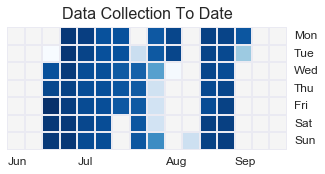

In [6]:
live = pd.DataFrame(df.groupby(["d"]).size(), columns=["Obs"])
live.index = pd.to_datetime(live.index)

fig, [ax] = calmap.calendarplot(live[~live.index.isnull()]["Obs"], 
                                cmap="Blues", fig_kws=dict(figsize=(10,2)))

ax.set_ylabel("")
ax.set_xlim(6*4, 10*4)
ax.set_xticklabels(ax.get_xticklabels(), ha="left")
ax.tick_params(axis="both", which="both", labelsize=12)
ax.set_title("Data Collection To Date", fontsize=16, y=1.02)

# Borough Averages

In [7]:
bb = ["Manhattan", "Brooklyn", "Bronx", "Queens", "Staten Island"]
hol = np.append(df["20170704"].index.values, df["20170904"].index.values)

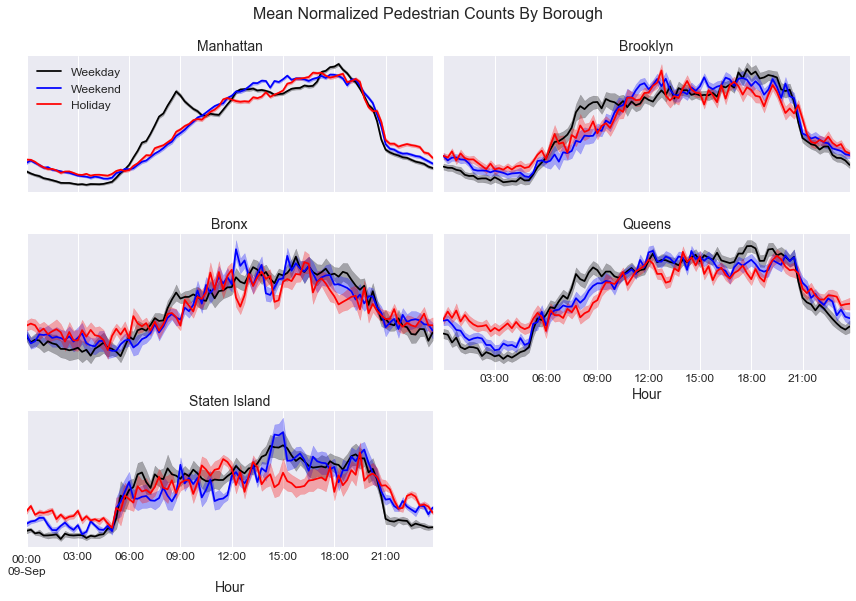

In [8]:
saved_data = True

fig, [r1, r2, r3] = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(12, 8))
fig.delaxes(r3[1])

for boro, ax in zip(bb, np.hstack([r1, r2, r3])):
    if not saved_data:
        # -- Select relevant cameras and exclude rain days.
        tmp = df[(df.cam_id.isin(cams[(cams.boro == boro) & (cams.people == 1)].cam_id.values))]
        tmp = tmp[tmp.d.isin(prec[prec.PRCP < 0.05].d.values)]

        # -- Subset the data into weekdays, weekends, and holidays.
        wd = cam_ts(tmp[(tmp.index.weekday < 5) & (~tmp.index.isin(hol))])
        we = cam_ts(tmp[tmp.index.weekday >= 5])
        hd = cam_ts(tmp[tmp.index.isin(hol)])

        # -- Save dataframes (time saving).
        wd.to_pickle("../data/results/{}_wd.pkl".format(boro.lower()))
        we.to_pickle("../data/results/{}_we.pkl".format(boro.lower()))
        hd.to_pickle("../data/results/{}_hd.pkl".format(boro.lower()))
    else:
        wd = pd.read_pickle("../data/results/{}_wd.pkl".format(boro.lower()))
        we = pd.read_pickle("../data/results/{}_we.pkl".format(boro.lower()))
        hd = pd.read_pickle("../data/results/{}_hd.pkl".format(boro.lower()))
    
    # -- Mean normalize each camera.
    wd_ = ((wd.T - wd.T.mean()) / wd.T.std()).T
    we_ = ((we.T - we.T.mean()) / we.T.std()).T
    hd_ = ((hd.T - hd.T.mean()) / hd.T.std()).T
    
    # -- Find mean & std dev across mean normalized cameras.
    wd_mean, wd_std = wd_.mean(), wd_.std()
    we_mean, we_std = we_.mean(), wd_.std()
    hd_mean, hd_std = hd_.mean(), wd_.std()
    
    # -- Plot
    wd_mean.T.plot(ax=ax, c="k")
    we_mean.T.plot(ax=ax, c="b")
    hd_mean.T.plot(ax=ax, c="r")

    wd_pm = (wd_std / np.sqrt(len(wd)))
    we_pm = (we_std / np.sqrt(len(we)))
    hd_pm = (hd_std / np.sqrt(len(hd)))
    
    ax.fill_between(wd_mean.index, wd_mean + wd_pm, wd_mean - wd_pm, color="k", alpha=0.3)
    ax.fill_between(we_mean.index, we_mean + we_pm, we_mean - we_pm, color="b", alpha=0.3)
    ax.fill_between(hd_mean.index, hd_mean + hd_pm, hd_mean - hd_pm, color="r", alpha=0.3)
    
    ax.set_yticklabels([])
    ax.set_xlabel("Hour", fontsize=14)
    ax.tick_params(axis="both", which="both", labelsize=12)
    ax.grid(False)
    ax.grid(True, which="both", axis="x")
    ax.set_title(boro, fontsize=14)
    
r1[0].legend(r1[0].get_lines(), ["Weekday", "Weekend", "Holiday"], fontsize=12)
fig.suptitle("Mean Normalized Pedestrian Counts By Borough", y=1.04, fontsize=16)
fig.tight_layout()

# Manhattan Time Series Image

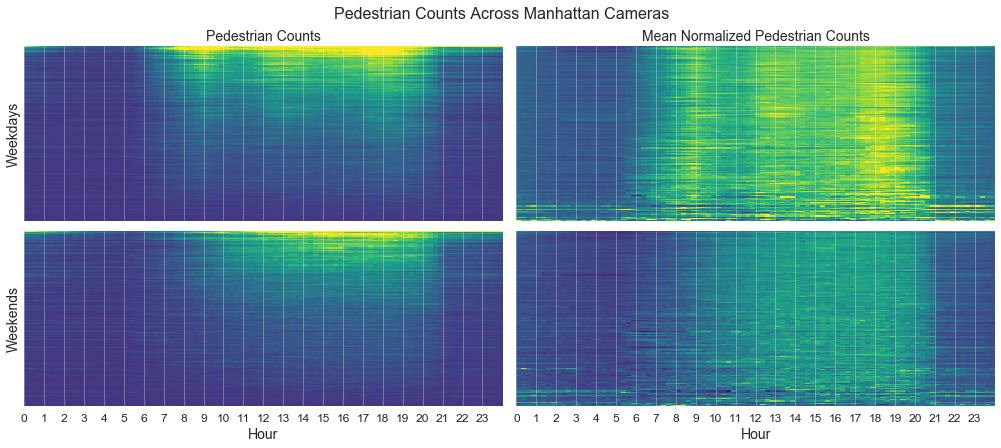

In [9]:
fig, [r1, r2] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 6))

wd = pd.read_pickle("../data/results/manhattan_wd.pkl")
we = pd.read_pickle("../data/results/manhattan_we.pkl")

wd = wd.iloc[np.flipud(wd.mean(axis=1).argsort())]
we = we.iloc[np.flipud(we.mean(axis=1).argsort())]

wd_ = ((wd.T - wd.T.mean()) / wd.T.std()).T
we_ = ((we.T - we.T.mean()) / we.T.std()).T

for dd, ax in zip([wd, wd_, we, we_], np.hstack([r1, r2])):
    im = ax.imshow(dd, cmap="viridis", aspect="auto")
    mi, ma = int(dd.min().min()), int(dd.max().max())
    
    if ax in [r1[0], r2[0]]:
        im.set_clim(-2, ma - ma * 0.4)
    else:
        im.set_clim(mi + mi * 0.3, ma - ma * 0.3)
    
    ax.set_yticklabels([])
    ax.grid(alpha=0.3)
    ax.grid(False, axis="y")

for ax in r2:
    ax.set_xticks([x - 0.5 for x in np.arange(0, 96, 4)])
    ax.set_xticklabels(range(24))
    ax.set_xlabel("Hour", fontsize=14)
    ax.tick_params(axis="both", which="both", labelsize=12)

r1[0].set_title("Pedestrian Counts", fontsize=14)
r1[0].set_ylabel("Weekdays", fontsize=14, labelpad=-4)
r1[1].set_title("Mean Normalized Pedestrian Counts", fontsize=14)
r2[0].set_ylabel("Weekends", fontsize=14, labelpad=-4)

fig.suptitle("Pedestrian Counts Across Manhattan Cameras", fontsize=16, y=1.03)
fig.tight_layout()

# Anomaly Images

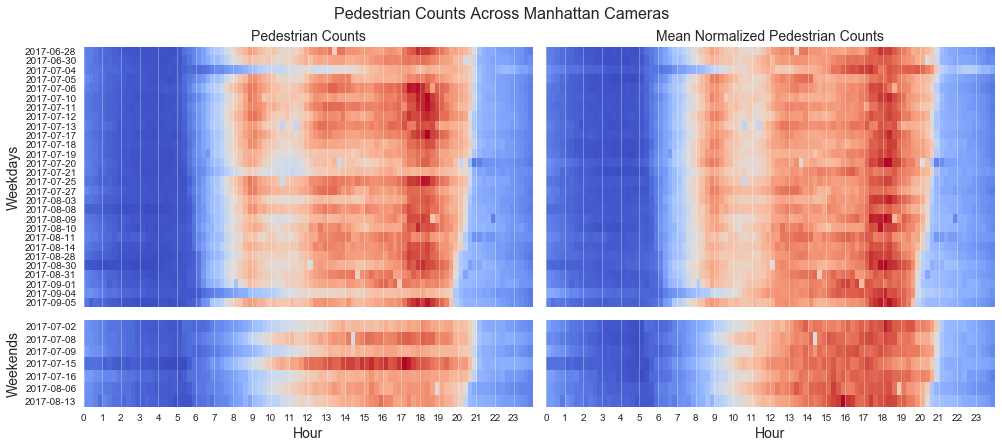

In [10]:
boro = "Manhattan"
saved_data = True

if not saved_data:
    tmp = df[(df.cam_id.isin(cams[(cams.boro == boro) & (cams.people == 1)].cam_id.values))]
    tmp = tmp[tmp.d.isin(prec[prec.PRCP < 0.05].d.values)]
    wd = tmp[tmp.index.weekday < 5]
    we = tmp[tmp.index.weekday >= 5]

    wd.to_pickle("../data/results/{}_wd_anomalies.pkl".format(boro.lower()))
    we.to_pickle("../data/results/{}_we_anomalies.pkl".format(boro.lower()))

else:
    wd = pd.read_pickle("../data/results/{}_wd_anomalies.pkl".format(boro.lower()))
    we = pd.read_pickle("../data/results/{}_we_anomalies.pkl".format(boro.lower()))

wd_ = wd.groupby(["cam_id", "d", "t"]).mean().unstack(level=[0, 1]).dropna(axis=1)
wd_ = wd_.stack([1, 2]).reset_index().drop("cam_id", axis=1).groupby(["d", "t"]).mean().unstack(1)
we_ = we.groupby(["cam_id", "d", "t"]).mean().unstack(level=[0, 1]).dropna(axis=1)
we_ = we_.stack([1, 2]).reset_index().drop("cam_id", axis=1).groupby(["d", "t"]).mean().unstack(1)

fig, [r1, r2] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 6),
                             gridspec_kw={"height_ratios": [3, 1]})

for [axl, axr], dd in zip([r1, r2], [wd_, we_]):
    axl.imshow(dd, cmap="coolwarm", aspect="auto")
    axl.set_yticks(range(len(dd.index)))
    axl.set_yticklabels(dd.index)

    axr.imshow(((dd.T - dd.T.mean()) / dd.T.std()).T, cmap="coolwarm", aspect="auto")
    axr.set_yticklabels([])

for ax in fig.get_axes():
    ax.grid(alpha=0.3)
    ax.grid(False, axis="y")
    ax.tick_params(axis="both", which="both", labelsize=10)

for ax in r2:
    ax.set_xticks([x - 0.5 for x in np.arange(0, 96, 4)])
    ax.set_xticklabels(range(24))
    ax.set_xlabel("Hour", fontsize=14)
    
r1[0].set_title("Pedestrian Counts", fontsize=14)
r1[0].set_ylabel("Weekdays", fontsize=14)
r1[1].set_title("Mean Normalized Pedestrian Counts", fontsize=14)
r2[0].set_ylabel("Weekends", fontsize=14)

fig.suptitle("Pedestrian Counts Across Manhattan Cameras", fontsize=16, y=1.03)
fig.tight_layout()

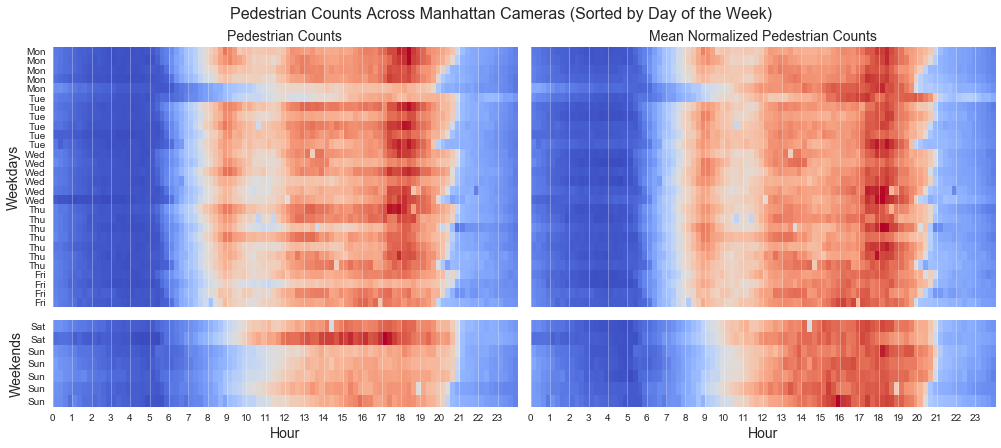

In [11]:
fig, [r1, r2] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 6),
                             gridspec_kw={"height_ratios": [3, 1]})

for [axl, axr], dd in zip([r1, r2], [wd_, we_]):
    test = dd.copy()
    test.index = pd.to_datetime(test.index)
    test["wd"] = test.index.weekday
    test = test.set_index("wd", append=True).sort_index(level=1)
    
    axl.imshow(test, cmap="coolwarm", aspect="auto")
    axl.set_yticks(range(len(test.index)))
    axl.set_yticklabels([x[:3] for x in test.index.get_level_values(0).weekday_name])

    axr.imshow(((test.T - test.T.mean()) / test.T.std()).T, cmap="coolwarm", aspect="auto")
    axr.set_yticklabels([])

for ax in fig.get_axes():
    ax.grid(alpha=0.3)
    ax.grid(False, axis="y")
    ax.tick_params(axis="both", which="both", labelsize=10)

for ax in r2:
    ax.set_xticks([x - 0.5 for x in np.arange(0, 96, 4)])
    ax.set_xticklabels(range(24))
    ax.set_xlabel("Hour", fontsize=14)
    
r1[0].set_title("Pedestrian Counts", fontsize=14)
r1[0].set_ylabel("Weekdays", fontsize=14)
r1[1].set_title("Mean Normalized Pedestrian Counts", fontsize=14)
r2[0].set_ylabel("Weekends", fontsize=14)

fig.suptitle("Pedestrian Counts Across Manhattan Cameras (Sorted by Day of the Week)", fontsize=16, y=1.03)
fig.tight_layout()

# Plot All Time Series

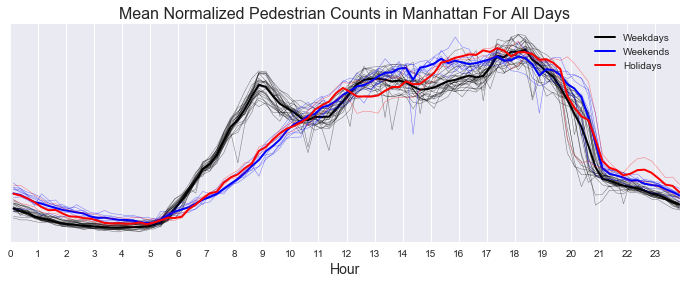

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

wd_ts = (wd_.T.drop(["2017-07-04", "2017-09-04"], axis=1)).T
hd_ts = wd_.T.loc[:,  ["2017-07-04", "2017-09-04"]].T

for dd, cc in zip([wd_ts, we_, hd_ts], ["k", "b", "r"]):
    days = ((dd.T - dd.T.mean()) / dd.T.std())
    mday = dd.mean()
    mday_ = ((mday - mday.mean()) / mday.std())
    days.plot(c=cc, alpha=0.5, lw=0.5, legend=False, ax=ax)
    mday_.plot(c=cc, lw=2, ax=ax)

ax.set_yticks([])
ax.set_xticks([x - 0.5 for x in np.arange(0, 96, 4)])
ax.set_xticklabels(range(24))
ax.set_xlabel("Hour", fontsize=14)
ax.tick_params(axis="both", which="both", labelsize=10)
ax.set_title("Mean Normalized Pedestrian Counts in Manhattan For All Days", fontsize=16)

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[i] for i in range(len(handles)) 
           if [lab == "None" for lab in labels][i]],
          ["Weekdays", "Weekends", "Holidays"])

# Anomaly Regression

/Users/JordanVani/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


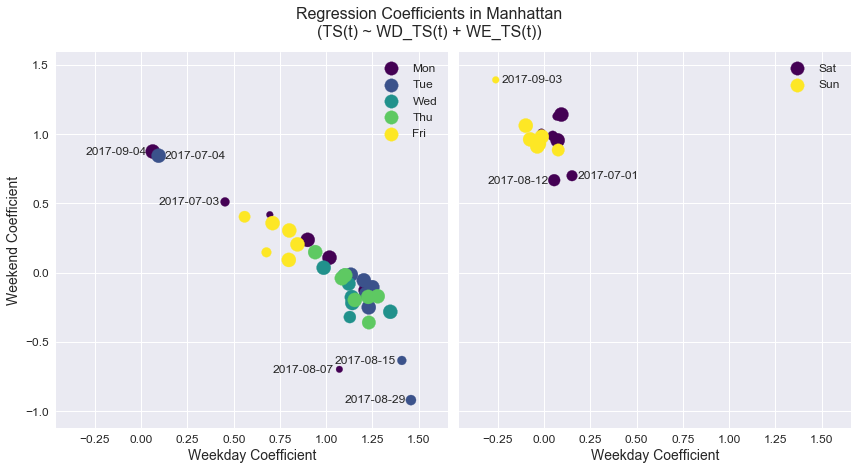

In [13]:
boro = "Manhattan"
saved_data = True

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

if not saved_data:
    tmp = df[(df.cam_id.isin(cams[(cams.boro == boro) & (cams.people == 1)].cam_id.values))]
    wd = tmp[tmp.index.weekday < 5]
    we = tmp[tmp.index.weekday >= 5]

    wd_ = wd.groupby(["cam_id", "d", "t"]).mean().unstack(level=[0, 1]).dropna(axis=1)
    wd_ = wd_.stack([1, 2]).reset_index().drop("cam_id", axis=1).groupby(["d", "t"]).mean().unstack(1)
    we_ = we.groupby(["cam_id", "d", "t"]).mean().unstack(level=[0, 1]).dropna(axis=1)
    we_ = we_.stack([1, 2]).reset_index().drop("cam_id", axis=1).groupby(["d", "t"]).mean().unstack(1)

    tmp = pd.concat([wd_, we_]).T.reset_index(level=0, drop=True)
    data = []
    for idx in tmp.columns:
        lm_dd = pd.concat([tmp[idx], wd_.mean().reset_index(level=0, drop=True),
                           we_.mean().reset_index(level=0, drop=True)], axis=1
                         ).rename(columns={idx: "c", 0: "wd", 1: "we"})
        lm = smf.ols(formula="c ~ wd + we", data=lm_dd).fit()
        data.append([pd.datetime(int(idx[:4]), int(idx[5:7]), int(idx[-2:])),
                     lm.params.wd, lm.params.we, lm.params.Intercept])
    data = pd.DataFrame(data, columns=["day", "wd_coef", "we_coef", "intercept"])
    data = data.merge(prec.reset_index(), left_on="day", right_on="DATE")

    data.to_pickle("../data/results/{}_anom_reg.pkl".format(boro.lower()))

else:
    data = pd.read_pickle("../data/results/{}_anom_reg.pkl".format(boro.lower()))

xlim = [data.wd_coef.min() - .2, data.wd_coef.max() + .2]
ylim = [data.we_coef.min() - .2, data.we_coef.max() + .2]

wd_reg = data[data.DATE.dt.weekday < 5]
we_reg = data[data.DATE.dt.weekday >= 5]

for ax, dd in zip([ax1, ax2], [wd_reg, we_reg]):
    grps = dd.groupby(dd.DATE.dt.weekday)
    color = iter(cm.viridis(np.linspace(0, 1, len(grps))))
    for nm, grp in grps:
        grp = grp.sort_values("PRCP")
        ax.scatter(grp.wd_coef, grp.we_coef, label=list(calendar.day_abbr)[nm],
                   c=next(color), s=(200 - 180 * np.sqrt(grp.PRCP)))
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("Weekday Coefficient", fontsize=14)
    
    texts = []
    for i, txt in enumerate(dd.d):
        wd_coef, we_coef = dd.wd_coef.values[i], dd.we_coef.values[i]
        if (abs(wd_coef - dd.wd_coef.values.mean()) > 1.5 * dd.wd_coef.values.std() or
            abs(we_coef - dd.we_coef.values.mean()) > 1.5 * dd.we_coef.values.std()):
            if i in [35, 31, 2, 23, 29, 10]:   
                ax.text(wd_coef - 0.03, we_coef, txt, fontsize=12, va="center", ha="right")
            else:
                ax.text(wd_coef + 0.03, we_coef, txt, fontsize=12, va="center", ha="left")

    ax.tick_params(axis="both", which="both", labelsize=12)
    ax.legend(fontsize=12)
    for ii in ax.legend_.legendHandles:
        ii.set_sizes([180])

ax1.set_ylabel("Weekend Coefficient", fontsize=14)
fig.suptitle("Regression Coefficients in Manhattan\n(TS(t) ~ WD_TS(t) + WE_TS(t))", fontsize=16, y=1.08)
fig.tight_layout()

# Day of Week Plot

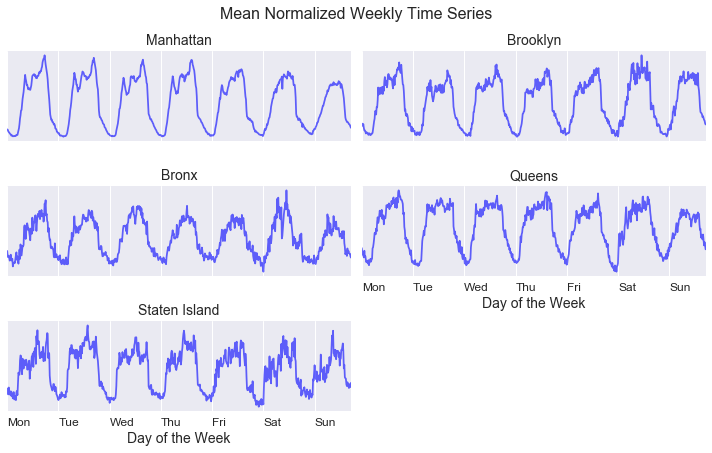

In [14]:
saved_data = True

fig, [r1, r2, r3] = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))
fig.delaxes(r3[1])

color = iter(cm.viridis(np.linspace(0, 1, len(bb))))

for boro, ax in zip(bb, np.hstack([r1, r2, r3])):
    if not saved_data:
        # -- Select relevant cameras and exclude rain days.
        tmp = df[(df.cam_id.isin(cams[(cams.boro == boro) & (cams.people == 1)].cam_id.values))]
        tmp = tmp[tmp.d.isin(prec[prec.PRCP < 0.05].d.values) & (~tmp.index.isin(hol))]
        tmp["dd"] = tmp.index.dayofweek
        tmp = tmp.groupby(["cam_id", "dd", "t"]).mean().unstack(level=0)
        tmp.to_pickle("../data/results/{}_dayofweek.pkl".format(boro.lower()))
    
    else:
        tmp = pd.read_pickle("../data/results/{}_dayofweek.pkl".format(boro.lower()))
        
    week = ((tmp - tmp.mean()) / tmp.std())
    week.T.mean().plot(ax=ax, c="b", alpha=0.6)
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel("")
    ax.grid(False, which="both", axis="y")
    ax.set_title(boro, fontsize=14)

for ax in [r3[0], r2[1]]:
    ax.set_xticklabels(list(calendar.day_abbr), ha="left")
    ax.tick_params(axis="both", which="both", labelsize=12)
    ax.set_xlabel("Day of the Week", fontsize=14)
    
fig.suptitle("Mean Normalized Weekly Time Series", fontsize=16, y=1.04)
fig.tight_layout()

# Neighborhood Time Series

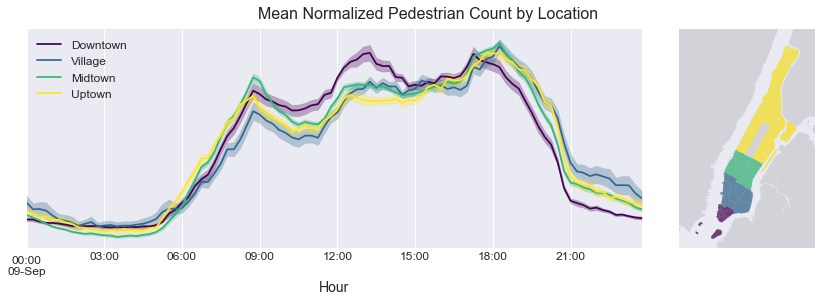

In [15]:
zip_locs = {'10115': 'uptown', '10040': 'uptown', '10075': 'uptown', '10004': 'downtown', '10005': 'downtown', '10006': 'downtown', '10007': 'downtown', '10001': 'midtown', '10002': 'village', '10065': 'uptown', '10165': 'uptown', '10069': 'uptown', '10044': 'uptown', '10275': 'uptown', '10012': 'village', '10013': 'village', '10128': 'uptown', '10028': 'uptown', '10029': 'uptown', '10026': 'uptown', '10027': 'uptown', '10024': 'uptown', '10025': 'uptown', '10022': 'midtown', '10023': 'uptown', '10020': 'midtown', '10021': 'uptown', '10010': 'midtown', '10031': 'uptown', '10003': 'village', '10011': 'village', '10030': 'uptown', '10009': 'village', '10032': 'uptown', '10014': 'village', '10282': 'downtown', '10280': 'downtown', '10281': 'downtown', '10019': 'midtown', '10018': 'midtown', '10039': 'uptown', '10038': 'downtown', '10035': 'uptown', '10034': 'uptown', '10037': 'uptown', '10036': 'midtown', '10017': 'midtown', '10016': 'midtown', '10033': 'uptown', '10111': 'midtown', '00083': 'uptown', '10048': 'downtown'}

ny = gp.read_file("../data/external/nyc_shp/nybb.shp")
ny = ny.to_crs({"init": "epsg:2263"})

nj = gp.read_file("../data/external/nj_shp/New_Jersey_Counties.shp")
nj = nj.to_crs({"init": "epsg:2263"})

zc = gp.read_file("../data/external/nyc_zip/ZIP_CODE_040114.shp")
zc = zc.to_crs({"init": "epsg:2263"})
zc = zc[(zc.PO_NAME == "New York") & (zc.BLDGZIP == "0")]
zc["location"] = zc.ZIPCODE.replace(zip_locs).str.title()

mn_cams = cams[(cams.boro == "Manhattan") & (cams.people == 1)].copy()
mn_cams["location"] = mn_cams.zipcode.replace(zip_locs).str.title()
mn_cams = mn_cams.set_index("cam_id")[["location"]]

wd = pd.read_pickle("../data/results/manhattan_wd.pkl")
wd_ = ((wd.T - wd.T.mean()) / wd.T.std()).T

mn_ts = mn_cams.merge(wd_, left_index=True, right_index=True).groupby("location")

ts_mea = mn_ts.mean()
ts_std = mn_ts.std()
ts_siz = mn_ts.size()
std_err = ts_std.T / np.sqrt(ts_siz)

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), 
                       gridspec_kw={"width_ratios":[3, 1]})

ax2.set_aspect("equal")
ax2.set_xlim(965000, 1015000)
ax2.set_ylim(185000, 265000)
ax2.grid(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

nj.plot(ax=ax2, facecolor="k", alpha=0.1)
ny.plot(ax=ax2, facecolor="k", alpha=0.1)

color = iter(cm.viridis(np.linspace(0, 1, len(ts_mea.T.columns))))
for col in ["Downtown", "Village", "Midtown", "Uptown"]:
    cc = next(color)
    ts_mea.T[col].plot(ax=ax1, c=cc)
    ax1.fill_between(ts_mea.T.index, ts_mea.T[col] + std_err[col], 
                    ts_mea.T[col] - std_err[col], color=cc, alpha=0.3)
    zc[zc["location"] == col].plot(ax=ax2, color=cc, alpha=0.7)
ax1.tick_params(axis="both", which="both", labelsize=12)  
ax1.set_xlabel("Hour", fontsize=14)
ax1.set_yticks([])
ax1.grid(True, which="both")
ax1.legend(fontsize=12, loc="upper left")
fig.suptitle("Mean Normalized Pedestrian Count by Location", fontsize=16, y=1.04)
fig.tight_layout()


# Histogram of Values

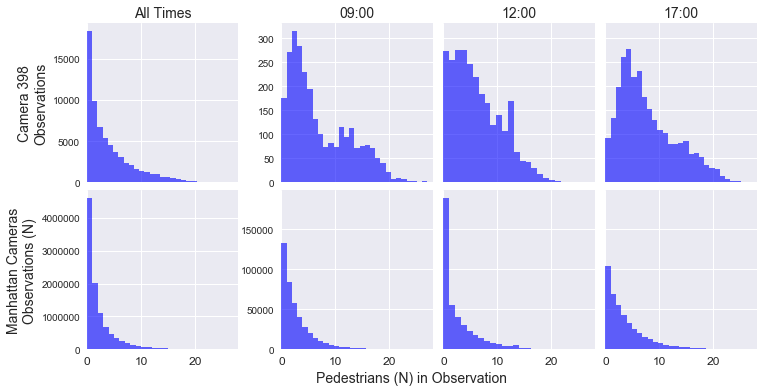

In [16]:
cam_id_ = 398
fig = plt.figure(figsize=(12, 6))
gs1 = gridspec.GridSpec(2, 21)
gs1.update(hspace=0.05, wspace=0.5)
ax1 = plt.subplot(gs1[0, :5])
ax5 = plt.subplot(gs1[1, :5])
gs2 = gridspec.GridSpec(2, 21)
gs2.update(hspace=0.05, wspace=0.5)
ax2 = plt.subplot(gs2[0, 6:11])
ax3 = plt.subplot(gs2[0, 11:16])
ax4 = plt.subplot(gs2[0, 16:])
ax6 = plt.subplot(gs2[1, 6:11])
ax7 = plt.subplot(gs2[1, 11:16])
ax8 = plt.subplot(gs2[1, 16:])

ax2.get_shared_y_axes().join(ax2, ax3, ax4)
ax6.get_shared_y_axes().join(ax6, ax7, ax8)
ax1.get_shared_x_axes().join(ax1, ax5)
ax2.get_shared_x_axes().join(ax2, ax6)
ax3.get_shared_x_axes().join(ax3, ax7)
ax4.get_shared_x_axes().join(ax4, ax8)

for ax in [ax3, ax4, ax7, ax8]:
    ax.set_yticklabels([])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticklabels([])

cc = df[df.cam_id == cam_id_]
mn_cc = df[(df.cam_id.isin(cams[(cams.boro == "Manhattan") & (cams.people == 1)].cam_id.values))]

cc["count"].hist(bins=len(cc["count"].unique()), ax=ax1, color="b", alpha=0.6)
ax1.set_xlim(0, cc["count"].max())

mn_cc["count"].hist(bins=len(mn_cc["count"].unique()), ax=ax5, color="b", alpha=0.6)

ax2.get_shared_y_axes().join(ax2, ax3, ax4)
ax6.get_shared_y_axes().join(ax6, ax7, ax8)

for tt, (axt, axb) in zip(["09", "12", "17"], zip([ax2, ax3, ax4], [ax6, ax7, ax8])):
    cc[cc.t.str[:2] == tt]["count"].hist(
        bins=len(cc[cc.t.str[:2] == tt]["count"].unique()), ax=axt, color="b", alpha=0.6)
    
    mn_cc[mn_cc.t.str[:2] == tt]["count"].hist(
        bins=len(mn_cc[mn_cc.t.str[:2] == tt]["count"].unique()), ax=axb, color="b", alpha=0.6)
    
    axb.set_xlim(0, cc["count"].max())

for ax, tt in zip([ax1, ax2, ax3, ax4], ["All Times", "09:00", "12:00", "17:00"]):
    ax.set_title(tt, fontsize=14)
    
for ax in fig.get_axes():
    ax.tick_params(axis="x", which="both", labelsize=12)  

ax1.set_ylabel("Camera {}\nObservations".format(cam_id_), fontsize=14)
ax5.set_ylabel("Manhattan Cameras\nObservations (N)", fontsize=14)
fig.text(.5, 0.05, "Pedestrians (N) in Observation", fontsize=14, ha="center")